In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import DataStructs, Descriptors, rdFingerprintGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data_dir = "/home/pervinco/Datasets/leash-bio"
save_dir = f"{data_dir}/split_sets"

train_csv = f"{data_dir}/train.csv"
test_csv = f"{data_dir}/test.csv"

train_parquet = f"{data_dir}/train.parquet"
test_parquet = f'{data_dir}/test.parquet'

os.listdir(data_dir)

['test.parquet',
 'train.csv',
 'test.csv',
 'train.parquet',
 'sample_submission.csv']

In [3]:
LIMIT = 200000
con = duckdb.connect()
data = con.query(f"""(SELECT *
                      FROM parquet_scan('{train_parquet}')
                      WHERE binds = 0
                      ORDER BY random()
                      LIMIT {LIMIT})
                      UNION ALL
                      (SELECT *
                      FROM parquet_scan('{train_parquet}')
                      WHERE binds = 1
                      ORDER BY random()
                      LIMIT {LIMIT})""").df()

con.close()

In [4]:
print(data.shape)
bind_0_count = data[data['binds'] == 0].shape[0]
bind_1_count = data[data['binds'] == 1].shape[0]

print(bind_0_count, bind_1_count)

(400000, 7)
200000 200000


In [5]:
descriptor_names = [desc[0] for desc in Descriptors._descList]
descriptor_functions = [desc[1] for desc in Descriptors._descList]

print(len(descriptor_names))
print(descriptor_names)

210
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10'

In [6]:
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [float('nan')] * len(descriptor_names)
    descriptors = [desc(mol) for desc in descriptor_functions]
    return descriptors


In [7]:
descriptor_df = pd.DataFrame(data['molecule_smiles'].apply(calculate_descriptors).tolist(), columns=descriptor_names)
excluded_descriptors = descriptor_df.columns[descriptor_df.isna().any()].tolist()

# NaN 값을 포함한 descriptor 제거
descriptor_df.drop(columns=excluded_descriptors, inplace=True)
used_descriptor = descriptor_df.columns.tolist()

print(f"제외된 descriptors: {excluded_descriptors}")
print(f"사용된 descriptors: {used_descriptor}")

제외된 descriptors: ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
사용된 descriptors: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA

In [8]:
data = pd.concat([data, descriptor_df], axis=1)
print(data.shape)
data.head()

(400000, 205)


,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,79942202,O=C(NC1(C(=O)O)CCOCC1)OCC1c2ccccc2-c2ccccc21,Cc1ccccc1-n1nc(C)c(CN)c1C.Cl.Cl,Nc1nc2ccc(Cl)cc2s1,Cc1ccccc1-n1nc(C)c(CNc2nc(Nc3nc4ccc(Cl)cc4s3)n...,sEH,0,13.042920,13.042920,0.162205,...,0,0,0,0,0,1,0,0,0,0
1,210271228,O=C(Nc1cccc(C(=O)O)c1C(=O)O)OCC1c2ccccc2-c2ccc...,C#CCOc1cccc(CN)c1.Cl,Cc1sc(N)c(C#N)c1C,C#CCOc1cccc(CNc2nc(Nc3cccc(C(=O)N[Dy])c3C(=O)O...,HSA,0,12.332515,12.332515,0.000654,...,0,0,0,1,0,0,0,1,0,0
2,76059842,O=C(NC1(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,Nc1ccc(-n2cccc2)cc1,CNC(=O)COCCN.Cl,CNC(=O)COCCNc1nc(Nc2ccc(-n3cccc3)cc2)nc(NC2(C(...,sEH,0,12.280232,12.280232,0.025807,...,0,0,0,0,0,0,0,0,2,0
3,52156515,Cc1cc(C)c(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)...,Nc1ccc2c(c1)C(O)CCC2,CCOC(=O)c1ncccc1N,CCOC(=O)c1ncccc1Nc1nc(Nc2ccc3c(c2)C(O)CCC3)nc(...,BRD4,0,12.736566,12.736566,0.076763,...,0,0,0,0,0,0,0,0,0,0
4,230810750,O=C(Nc1ncc(Br)nc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(O)cn1,COc1ccc(OC)c(N)c1,COc1ccc(OC)c(Nc2nc(Nc3ccc(O)cn3)nc(Nc3ncc(Br)n...,sEH,0,12.337674,12.337674,0.005517,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data.to_csv("./more_features.csv")

In [10]:
# minmax_scaler = MinMaxScaler()
# descriptor_df_minmax = pd.DataFrame(minmax_scaler.fit_transform(descriptor_df), columns=used_descriptor)

standard_scaler = StandardScaler()
descriptor_df_standard = pd.DataFrame(standard_scaler.fit_transform(descriptor_df), columns=used_descriptor)

In [11]:
# X와 y 설정
X = data[used_descriptor]
y = data['binds']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# 모델 예측
y_pred = model.predict(X_test)

# 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8466625
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     40051
           1       0.89      0.79      0.84     39949

    accuracy                           0.85     80000
   macro avg       0.85      0.85      0.85     80000
weighted avg       0.85      0.85      0.85     80000



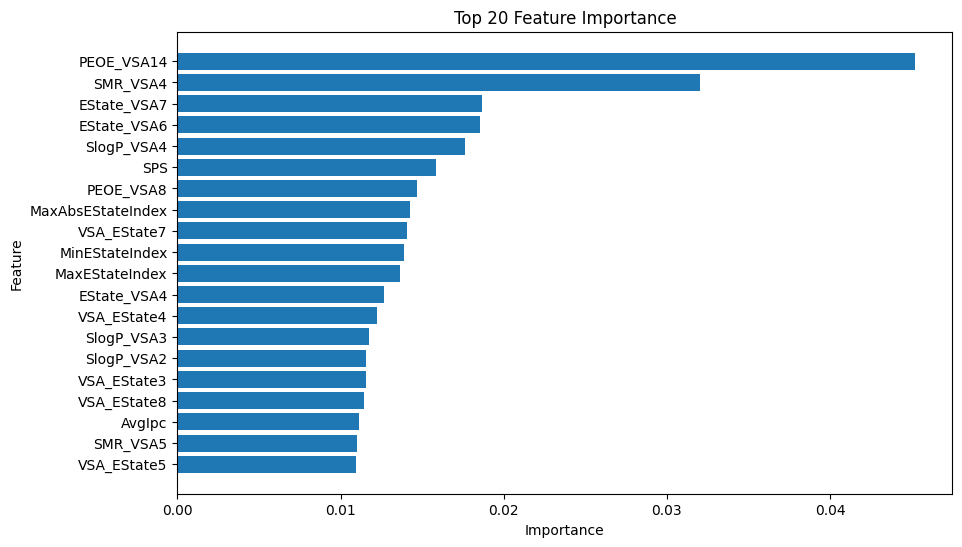

In [13]:
# Feature importance 계산
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_n = 20
top_features = importance_df.head(top_n)['Feature'].tolist()
top_importances = importance_df.head(top_n)['Importance'].tolist()

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [14]:
X_top = X[top_features]
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

print(X_train_top.shape, y_train.shape)
print(X_test_top.shape, y_test.shape)

(320000, 20) (320000,)
(80000, 20) (80000,)


In [15]:
model_top = RandomForestClassifier(n_estimators=100, random_state=42)
model_top.fit(X_train_top, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = model_top.predict(X_test_top)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.821625
              precision    recall  f1-score   support

           0       0.79      0.89      0.83     40051
           1       0.87      0.76      0.81     39949

    accuracy                           0.82     80000
   macro avg       0.83      0.82      0.82     80000
weighted avg       0.83      0.82      0.82     80000

